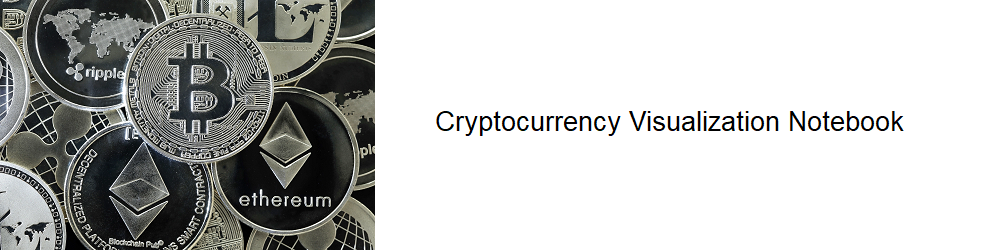

Welcome to our interactive cryptocurrency visualization notebook!

Run the cells below and fill in the inputs in Section 3 as instructed to create visualizations :)

(image source: https://www.nbcnews.com/mach/science/how-bitcoin-other-cryptocurrencies-could-kill-cash-ncna857036)

## 1. Set Up the Environment

Let's begin with some set up - make sure to have a `kaggle.json` file uploaded in the files to allow access to the dataset (https://www.kaggle.com/jessevent/all-crypto-currencies).

The next two cells may take a little bit of time to run.

In [ ]:
# perform installations
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install --upgrade plotly
!pip install chart-studio

# get the dataset from kaggle
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessevent/all-crypto-currencies # we are using data from https://www.kaggle.com/jessevent/all-crypto-currencies
!unzip all-crypto-currencies.zip

E: The repository 'https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release' no longer has a Release file.
     |████████████████████████████████| 27.7 MB 1.9 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
     |████████████████████████████████| 64 kB 1.7 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=9e31824b36954e1895338427f467ed8445a31f1fb42b364aefbb257ae1a3e183
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
 22% 5.00M/22.5M [00:00<00:00, 36.9MB/s]
100% 22.5M/22.5M [00:00<00:00, 104MB/s] 
Archive:  all-crypto-currencies.zip
  inflating: crypto-markets.csv      


In [ ]:
# set up spark environment - taken from CS 431 Assignments
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
import findspark
findspark.init()

# import libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import random
import matplotlib.pyplot as plt
import seaborn as sns
from chart_studio import plotly
import plotly.tools as tls
import plotly.express as px
import plotly.figure_factory as ff
from plotly.graph_objs import *
import pandas as pd
import numpy as np
from sklearn import *

spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

Set global variables here:

In [ ]:
# limit all pandas DataFrames to have rows of row_limit to 2*row_limit
row_limit = 500

## 2. Set Up the Data

Create a Spark DataFrame from the original data set:

In [ ]:
# read in dataset
crypto_df = spark.read.option("header","true").csv("crypto-markets.csv",sep=',',inferSchema=True)
# define basic attributes
crypto_df = crypto_df.withColumn("return", crypto_df.close - crypto_df.open).cache()
# create table and show
crypto_df.createOrReplaceTempView("crypto_df")
crypto_df.show()

+-------+------+-------+-------------------+-------+------+------+------+------+------+----------+-----------+------+-------------------+
|   slug|symbol|   name|               date|ranknow|  open|  high|   low| close|volume|    market|close_ratio|spread|             return|
+-------+------+-------+-------------------+-------+------+------+------+------+------+----------+-----------+------+-------------------+
|bitcoin|   BTC|Bitcoin|2013-04-28 00:00:00|      1| 135.3|135.98| 132.1|134.21|     0|1488566728|     0.5438|  3.88|-1.0900000000000034|
|bitcoin|   BTC|Bitcoin|2013-04-29 00:00:00|      1|134.44|147.49| 134.0|144.54|     0|1603768865|     0.7813| 13.49| 10.099999999999994|
|bitcoin|   BTC|Bitcoin|2013-04-30 00:00:00|      1| 144.0|146.93|134.05| 139.0|     0|1542813125|     0.3843| 12.88|               -5.0|
|bitcoin|   BTC|Bitcoin|2013-05-01 00:00:00|      1| 139.0|139.89|107.72|116.99|     0|1298954594|     0.2882| 32.17|-22.010000000000005|
|bitcoin|   BTC|Bitcoin|2013-05-02

## 3. Visualizations

### 3.1. Single Coin Over Time

To begin, let's first create basic line plots over time.

Define function that displays the single coin plots:

In [ ]:
def single_coin_vis(coin, columns, agg):

  # 1. Create dataframe from given coin
  coin_df = spark.sql("SELECT * \
                       FROM crypto_df \
                       WHERE symbol = '{}'".format(coin))
  coin_df.createOrReplaceTempView("coin_df")

  # 2. Limit the number of rows that will appear in the pandas dataframe using the chosen method of aggregation
  nrows = coin_df.count()
  columns_df = coin_df.withColumn("id", monotonically_increasing_id()+1)
  columns_df.createOrReplaceTempView("columns_df")
  if nrows > row_limit:
    n_days = nrows//row_limit
    for c in columns:
      columns_df = spark.sql("SELECT *, \
                              {}({}) OVER \
                              (ORDER BY date ROWS BETWEEN {} PRECEDING AND CURRENT ROW) AS {} \
                              FROM columns_df".format(agg, c, n_days, c + "_agg"))
      columns_df.createOrReplaceTempView("columns_df")
    columns_df = spark.sql('select * from columns_df where id % {} = 0'.format(n_days))
    columns = [c + "_agg" for c in columns]
  columns_df.createOrReplaceTempView("columns_df")

  # 3. Convert to pandas and display it in a plot
  crypto_pd = columns_df.toPandas()
  crypto_pd["date"] = pd.to_datetime(crypto_pd["date"])

  # 4. Display plot
  single_coin = crypto_pd.loc[:, ['date'] + columns]
  single_coin.set_index('date').plot(figsize = (20, 10))


Enter the coin you'd like to visualize, the attribute and the method of aggregation:

Enter a coin (by symbol): btc
Enter desired attribute(s) (separate multiple columns by a space): high low open close
Enter desired aggregation method to decrease DataFrame size (avg, sum, max or min): avg


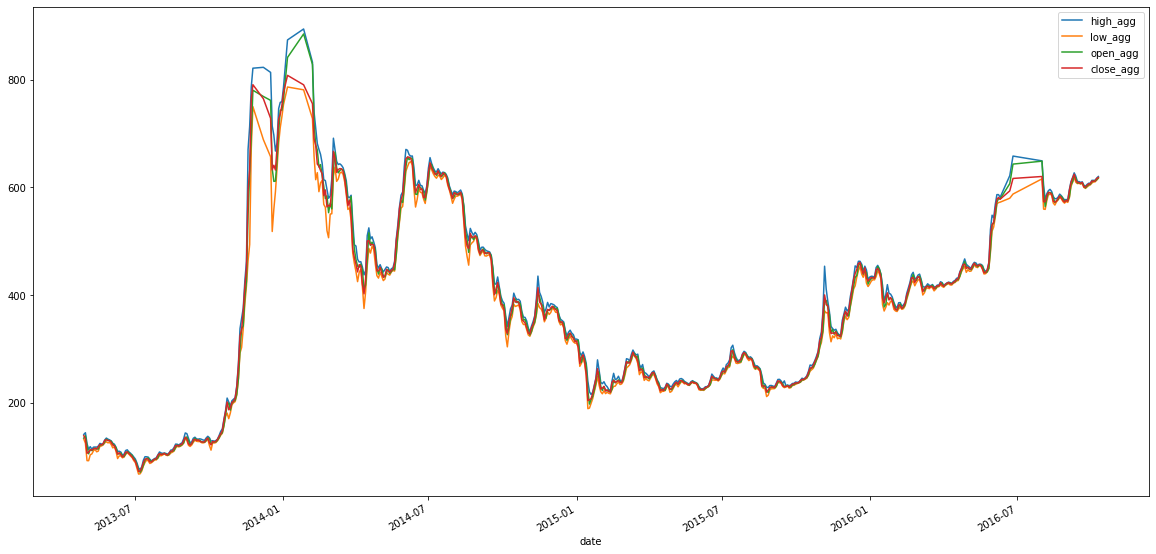

In [ ]:
# 1. Get coin symbol
while True:
  q = input("Enter a coin (by symbol): ")
  if len(q) == 0:
      break
  else:
    coin = q.upper()
    # verify that the symbol exists in the data set
    try:
      if (crypto_df.filter("symbol = '{}'".format(coin)).count() < 1):
        raise ValueError
      break
    except ValueError:
      print("Symbol not found in data set, try a different one.")

# 2. Get columns to display
while True:
  q = input("Enter desired attribute(s) (separate multiple columns by a space): ")
  if len(q) == 0:
      break
  else:
    columns = q.split(" ")
    error = ""
    # verify that the columns exist in sql
    try:
      for c in columns:
        if c not in crypto_df.columns:
          error = c
          raise ValueError
      break
    except ValueError:
      print("Could not find the attribute: " + error)

# 3. Get columns to display
while True:
  q = input("Enter desired aggregation method to decrease DataFrame size (avg, sum, max or min): ")
  if len(q) == 0:
      break
  else:
    method = q.upper()
    agg = ["AVG", "SUM", "MAX", "MIN"]
    # verify that the method of aggregation exists
    try:
      if method not in agg:
          raise ValueError
      break
    except ValueError:
      print("Could not find the method: " + error)

# 4. Call the function
single_coin_vis(coin, columns, method)

### 3.2 Comparison

In [ ]:
def pie_plot(df, coins, title):
  # 1. Pie plot
  df_pd = df.toPandas()
  fig = px.pie(df_pd, values='value', names='symbol', title= title)
  fig.show()

In [ ]:
def line_plot(df, columns):

  pivot_columns = "'" + columns[0] + "'"
  for c in columns[1:]:
    pivot_columns += ", '" + c + "'"

  df.createOrReplaceTempView("df")

  pivot_df = spark.sql('select * from df pivot( min(value) for symbol in ({}))'.format(pivot_columns))

  # Reduce number of rows
  nrows = pivot_df.count()
  columns_df = pivot_df.withColumn("id", monotonically_increasing_id()+1)
  columns_df.createOrReplaceTempView("columns_df")
  if nrows > row_limit:
    n_days = nrows//row_limit
    for c in columns:
      columns_df = spark.sql("SELECT *, \
                              AVG ({}) OVER \
                              (ORDER BY date ROWS BETWEEN {} PRECEDING AND CURRENT ROW) AS {} \
                              FROM columns_df".format(c, n_days, c + "_agg"))
      columns_df.createOrReplaceTempView("columns_df")
    columns_df = spark.sql('select * from columns_df where id % {} = 0'.format(n_days))

  df_pd = columns_df.toPandas()
  df_pd["date"] = pd.to_datetime(df_pd["date"])
  df_pd.drop(columns = columns + ["id"], inplace = True)
  df_pd.reindex(["date"] + [c + "_agg" for c in columns], axis=1)
  df_pd.set_index("date").plot(figsize = (20, 10))

In [ ]:
def top_x(x, column, agg):
  # 1. Create dataframe from given coin
  top_df = spark.sql("SELECT symbol, {}({}) AS value \
                       FROM crypto_df \
                       GROUP BY symbol \
                       ORDER BY {}({}) DESC\
                       LIMIT {}".format(agg, column, agg, column, x))
  top_df.createOrReplaceTempView("coin_df")
  top_df.show()
  # 1.1. Extract coins
  coins = [row[0] for row in top_df.select('symbol').collect()]
  condition_str = "symbol = '" + coins[0] + "'"
  for c in coins[1:]:
    condition_str += " OR symbol = '" + c + "'"
  top_expanded_df = spark.sql("SELECT symbol, date, {} AS value\
                       FROM crypto_df \
                       WHERE {}".format(column, condition_str))
  # 2. Get plots
  pie_plot(top_df, coins, "Top {} Coins by {} of {}".format(x, agg, column))
  line_plot(top_expanded_df, coins)

In [ ]:
def list_coins(coins, column, agg):
  condition_str = "symbol = '" + coins[0] + "'"
  title = coins[0]
  for c in coins[1:]:
    condition_str += " OR symbol = '" + c + "'"
    title += ", " + c
  expanded_df = spark.sql("SELECT symbol, date, {} AS value\
                       FROM crypto_df \
                       WHERE {}".format(column, condition_str))
  expanded_df.createOrReplaceTempView("expanded_df")

  summary_df = spark.sql("SELECT symbol, {}(value) AS value \
                       FROM expanded_df \
                       GROUP BY symbol \
                       ORDER BY {}(value) DESC".format(agg, agg))
  summary_df.show()
  pie_plot(summary_df, coins, "Comparison of {} by {} of {}".format(title, agg, column))
  line_plot(expanded_df, coins)

To see the top __ most traded coins, enter a number.
Otherwise, enter a list of symbols separated by spaces to compare them: 100
Choose column to compare: high
Enter desired aggregation method on the column (avg, sum, max or min): avg
+-------+------------------+
| symbol|             value|
+-------+------------------+
|  BTWTY| 459128.1060430108|
|  NANOX| 211375.0017367458|
|     42|18405.243061686502|
|    RMC| 8520.094695431475|
|    PBT| 4318.871024590167|
| BITBTC|3562.5054362880883|
|   IDXM| 2687.831751592358|
|   CEFS|1663.6154461538463|
|BITGOLD|1447.1234792806874|
|    XOT| 913.4213864818034|
|   FOIN|  751.500641025641|
|    MKR| 742.3089540816325|
|   WETH|   561.57670846395|
|    300|486.24125260960346|
|    BCH|461.55958762886553|
|    BTC|374.93099315068514|
|  GBYTE|279.91328591749664|
|    XIN|259.56576002724813|
|    ZEC|238.76876640419945|
|    TER|  165.378123300199|
+-------+------------------+
only showing top 20 rows



/content/spark-2.4.8-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2195: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



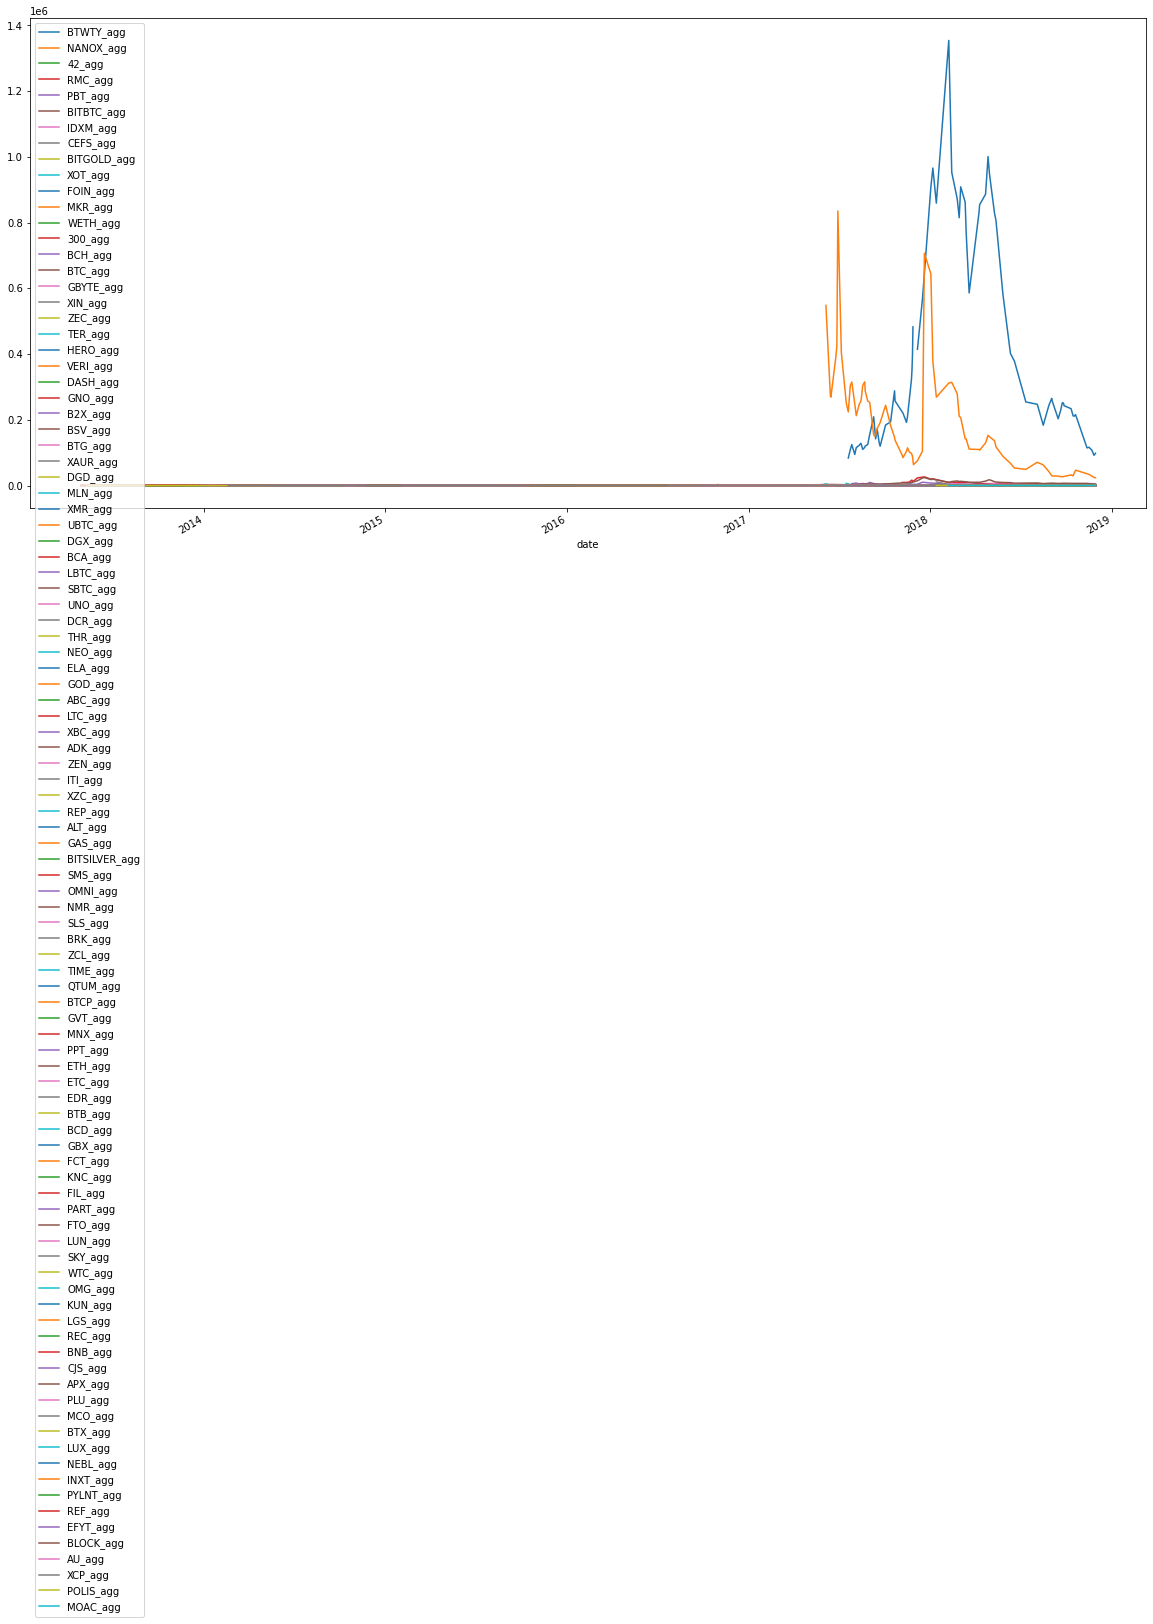

In [ ]:
while True:

  q = input("To see the top __ most traded coins, enter a number.\nOtherwise, enter a list of symbols separated by spaces to compare them: ")
  if len(q) == 0:
      break

  # top x
  if q.isnumeric():
    x = int(q)
    # choose column
    while True:
      c = input("Choose column to compare: ")
      error = ""
      # verify that the column exists in sql
      try:
        if c not in crypto_df.columns:
          error = c
          raise ValueError
        break
      except ValueError:
        print("Could not find the attribute: " + error)
    # choose method of aggregation
    while True:
      agg = ["AVG", "SUM", "MAX", "MIN"]
      a = input("Enter desired aggregation method on the column (avg, sum, max or min): ")
      method = a.upper()
      # verify that the method of aggregation exists
      try:
        if method not in agg:
            raise ValueError
        break
      except ValueError:
        print("Could not find the method: " + error)
    # call top_x function
    top_x(x, c, method)
    break

  # list of symbols to compare
  else:
    coins = q.upper().split(" ")
    error = ""
    try:
      for coin in coins:
        if (crypto_df.filter("symbol = '{}'".format(coin)).count() < 1):
          error = coin
          raise ValueError
    except ValueError:
      print("Symbol not found in data set: " + error)
    # choose column
    while True:
      c = input("Choose column to compare: ")
      error = ""
      # verify that the column exists in sql
      try:
        if c not in crypto_df.columns:
          error = c
          raise ValueError
        break
      except ValueError:
        print("Could not find the attribute: " + error)
    # choose method of aggregation
    while True:
      agg = ["AVG", "SUM", "MAX", "MIN"]
      a = input("Enter desired aggregation method on the column (avg, sum, max or min): ")
      method = a.upper()
      # verify that the method of aggregation exists
      try:
        if method not in agg:
            raise ValueError
        break
      except ValueError:
        print("Could not find the method: " + error)
    # call top_x function
    list_coins(coins, c, method)
    break

### 3.3 Statistics

First do some distribution analysis on a single coin from the aggregated results

In [ ]:
def single_coin_return_df(coin, columns, agg):
  # 1. Create dataframe from given coin
  coin_df = spark.sql("SELECT * \
                       FROM crypto_df \
                       WHERE symbol = '{}'".format(coin))
  coin_df.createOrReplaceTempView("coin_df")

  # 2. Limit the number of rows that will appear in the pandas dataframe using the chosen method of aggregation
  nrows = coin_df.count()
  columns_df = coin_df.withColumn("id", monotonically_increasing_id()+1)
  columns_df.createOrReplaceTempView("columns_df")
  if nrows > row_limit:
    n_days = nrows//row_limit



    for c in columns:
      columns_df = spark.sql("SELECT *, \
                              {}({}) OVER \
                              (ORDER BY date ROWS BETWEEN {} PRECEDING AND CURRENT ROW) AS {} \
                              FROM columns_df".format(agg, c, n_days, c + "_agg"))
      columns_df.createOrReplaceTempView("columns_df")
    columns_df = spark.sql('select * from columns_df where id % {} = 0'.format(n_days))
    columns = [c + "_agg" for c in columns]
  columns_df.createOrReplaceTempView("columns_df")

  # 3. Convert to pandas and display it in a plot
  crypto_pd = columns_df.toPandas()
  crypto_pd["date"] = pd.to_datetime(crypto_pd["date"])
  single_coin = crypto_pd.loc[:, ['date'] + columns]
  return single_coin

In [ ]:
# 1. Get coin symbol
while True:
  q = input("Enter a coin (by symbol): ")
  if len(q) == 0:
      break
  else:
    coin = q.upper()
    # verify that the symbol exists in the data set
    try:
      if (crypto_df.filter("symbol = '{}'".format(coin)).count() < 1):
        raise ValueError
      break
    except ValueError:
      print("Symbol not found in data set, try a different one.")

# 2. Get columns to display
while True:
  q = input("Enter desired attribute(s) (separate multiple columns by a space): ")
  if len(q) == 0:
      break
  else:
    columns = q.split(" ")
    error = ""
    # verify that the columns exist in sql
    try:
      for c in columns:
        if c not in crypto_df.columns:
          error = c
          raise ValueError
      break
    except ValueError:
      print("Could not find the attribute: " + error)

# 3. Get columns to display
while True:
  q = input("Enter desired aggregation method to decrease DataFrame size (avg, max or min): ")
  if len(q) == 0:
      break
  else:
    method = q.upper()
    agg = ["AVG", "MAX", "MIN"]
    # verify that the method of aggregation exists
    try:
      if method not in agg:
          raise ValueError
      break
    except ValueError:
      print("Could not find the attribute: " + error)

# 4. Call the function
df = single_coin_return_df(coin, columns, method)

We can view the first 5 rows of the dataset we obtained from the original and view the data types

In [ ]:
df.head()

In [ ]:
df.dtypes

We can get the desired columns

In [ ]:
cols = df.columns[1:]
cols


In [ ]:
# Convert the dtypes into floats
for i in cols:
  if df[i].dtype != 'float64':
    df[i] = df[i].astype('float64')


Can scale all values in the dataset to be between 0 and 1 for comparison purposes

In [ ]:
scaler = preprocessing.MinMaxScaler()
df[cols] = scaler.fit_transform(df[cols])

df.head()

We can scale everything between 0 and 1 to make it comparable

We can first create some histograms across the columns selected to see what kind of distribution they represnet

In [ ]:
for i in cols:
  fig = px.histogram(df, x = i, title = coin + " " + i + " Histogram")
  fig.show()

From the histograms, we can infer that the columns appear to be distibuted normally or multimodally distributed.

We can also create boxplots to visualize the spread across all the columns

In [ ]:
for i in cols:
  fig = px.box(df, y = i, title = coin + " " + i + " Boxplot",  points="all")
  fig.update_traces(quartilemethod="exclusive")
  fig.show()

From the histograms we can see that all columns have very similar variability and spread. This suggests that these columns are related to one another. Although, the scales may be different, it should not affect the relationship between the columns. They, potentially, could be scaled, but that would not much difference. However, for the purpose of plotting distribution, scaling them might be better for visualization purposes.

From the boxplots, we can assume that some of the columns are related, so we can create a heatmap to visualize how correlated they are.

In [ ]:
corr_df = df[cols].corr()
sns.heatmap(corr_df, annot = True)

From the heatmap, we can see that alot of the columns are very correlated to one another, except close_ratio_agg, which doesn't seem to be correlated with any other column.

Next we can make a distribution plot to test our hypotheses (from the histograms) that our data may be normally distributed or multimodally distributed.

In [ ]:
sns.pairplot(df[cols])

In [ ]:
g = sns.PairGrid(df[cols])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

From the above pairplots, we observe that the corresponding vars are correlated, as well as, the univariate distributions can be accurately estimated using a gaussian kernel. Specifically, each column can be estimated using a gaussian distribution or combination of gaussians.

Can create a more interactive plot using plotly instead of sns

In [ ]:
for i in range(len(cols)):
  fig = ff.create_distplot([df[cols[i]]], group_labels = [cols[i]], curve_type='kde', show_hist = False)
  fig2 = ff.create_distplot([df[cols[i]]], group_labels = [cols[i]], curve_type='normal',show_hist = False)
  fig.show()
  fig2.show()

We can see for most of the columns, a mixture of gaussians is better than using a singular gaussian model. However, we observe that one of the columns can be accurately approximated via a singular gaussian.

Next can do some visualizations across the entire dataset (i.e. with more than one coin)

Can follow a similar procedure as to with one coin

In [ ]:
def multi_coin_return_df(coin, columns, agg):
  # 1. Create dataframe from given coin
  coin_df = spark.sql("SELECT * \
                       FROM crypto_df \
                       WHERE symbol = '{}'".format(coin))
  coin_df.createOrReplaceTempView("coin_df")

  # 2. Limit the number of rows that will appear in the pandas dataframe using the chosen method of aggregation
  nrows = coin_df.count()
  columns_df = coin_df.withColumn("id", monotonically_increasing_id()+1)
  columns_df.createOrReplaceTempView("columns_df")
  if nrows > row_limit:
    n_days = nrows//row_limit



    for c in columns:
      columns_df = spark.sql("SELECT *, \
                              {}({}) OVER \
                              (ORDER BY date ROWS BETWEEN {} PRECEDING AND CURRENT ROW) AS {} \
                              FROM columns_df".format(agg, c, n_days, c + "_agg"))
      columns_df.createOrReplaceTempView("columns_df")
    columns_df = spark.sql('select * from columns_df where id % {} = 0'.format(n_days))
    columns = [c + "_agg" for c in columns]
  columns_df.createOrReplaceTempView("columns_df")

  # 3. Convert to pandas and display it in a plot
  crypto_pd = columns_df.toPandas()
  crypto_pd["date"] = pd.to_datetime(crypto_pd["date"])
  multi_coin = crypto_pd.loc[:, ['date', 'symbol'] + columns]
  return multi_coin

In [ ]:
while True:

  q = input("To see the top __ most traded coins, enter a number.\nOtherwise, enter a list of symbols separated by spaces to compare them: ")
  if len(q) == 0:
      break

  # top x
  if q.isnumeric():
    x = int(q)
    # ensure row limit is kept
    try:
      if x > 2*row_limit:
        raise ValueError
    except ValueError:
      print("Value entered can be at most " + str(2*row_limit))
      continue
    # choose column
    while True:
      c = input("Choose column to compare: ")
      error = ""
      # verify that the column exists in sql
      try:
        if c not in crypto_df.columns:
          error = c
          raise ValueError
        break
      except ValueError:
        print("Could not find the attribute: " + error)
    # choose method of aggregation
    while True:
      agg = ["AVG", "SUM", "MAX", "MIN"]
      a = input("Enter desired aggregation method on the column (avg, sum, max or min): ")
      method = a.upper()
      # verify that the method of aggregation exists
      try:
        if method not in agg:
            raise ValueError
        break
      except ValueError:
        print("Could not find the method: " + error)
    # call top_x function
    top_x(x, c, method)
    break

  # list of symbols to compare
  else:
    coins = q.upper().split(" ")
    error = ""
    try:
      for coin in coins:
        if (crypto_df.filter("symbol = '{}'".format(coin)).count() < 1):
          error = coin
          raise ValueError
    except ValueError:
      print("Symbol not found in data set: " + error)
    # choose column
    while True:
      c = input("Choose column to compare: ")
      error = ""
      # verify that the column exists in sql
      try:
        if c not in crypto_df.columns:
          error = c
          raise ValueError
        break
      except ValueError:
        print("Could not find the attribute: " + error)
    # choose method of aggregation
    while True:
      agg = ["AVG", "SUM", "MAX", "MIN"]
      a = input("Enter desired aggregation method on the column (avg, sum, max or min): ")
      method = a.upper()
      # verify that the method of aggregation exists
      try:
        if method not in agg:
            raise ValueError
        break
      except ValueError:
        print("Could not find the method: " + error)
    # call top_x function

    break



In [ ]:
appended_data = []

for i in coins:
  df = multi_coin_return_df(i, [c], method)
  appended_data.append(df)

appended_data = pd.concat(appended_data)

Now that we have the appended data, we can generate similar plots and compare

In [ ]:
cols = appended_data.columns[2:]
cols

In [ ]:
for i in cols:
  fig = px.histogram(appended_data, x = i, color = "symbol")
  fig.show()

We see similar gaussian behaviour among multiple coins

Can also create a boxplot


In [ ]:
for i in cols:
  fig = px.box(appended_data, x = i, color = "symbol", points = "all")
  fig.update_traces(quartilemethod="exclusive")
  fig.show()

Can observe the variability between the coins

Produce some density estimate plots

In [ ]:
# Get the unique symbols
sub_data = []
unique_symbols = appended_data.symbol.unique()

for i in unique_symbols:
  df1 = appended_data[appended_data.symbol == i]
  df2 = df1[cols]
  sub_data.append(df2)

In [ ]:
# Scale for distplot vis purposes
scaler = preprocessing.MinMaxScaler()
appended_data[cols] = scaler.fit_transform(appended_data[cols])

appended_data.head()

In [ ]:
for i in cols:
  fig = ff.create_distplot([appended_data[appended_data.symbol == a][i] for a in unique_symbols], group_labels = unique_symbols, curve_type='kde', show_hist = False)
  fig2 = ff.create_distplot([appended_data[appended_data.symbol == a][i] for a in unique_symbols], group_labels = unique_symbols, curve_type='normal',show_hist = False)
  fig.show()
  fig2.show()

### 3.4 Finance

### Given a Coin, Unit and Year, display the Profit/Loss

(year is years before 2018-Nov)

In [ ]:
#Get the coin and the date
coin = ""
while True:
  #get coin
  q = input("Enter a coin (by symbol): ")
  if len(q) == 0:
      break
  else:
    coin = q.upper()
    # verify that the symbol exists in the data set
    try:
      if (crypto_df.filter("symbol = '{}'".format(coin)).count() < 1):
        raise ValueError
      break
    except ValueError:
      print("Symbol not found in data set, try a different one.")


#Create dataframe from given coin
coin_df = spark.sql(
    """SELECT cast(date as date), close
                      FROM crypto_df \
                      WHERE symbol = '{}'""".format(coin))
coin_df.createOrReplaceTempView("coin_df")

while True:
  #get years
  dt = input("Input the start date YYYY-MM-DD: ")
  try:
      if (coin_df.filter("date = '{}'".format(dt)).count() < 1):
        raise ValueError
      break
  except ValueError:
      print("Date is not in dataset, try another one")


while True:
  #get units
  units = int(input("Input how many units: "))
  break

start_value = spark.sql(
"""
SELECT close FROM coin_df WHERE  date = '{}'
""".format(dt))

end_value = spark.sql(
"""
SELECT close FROM coin_df ORDER BY date DESC LIMIT 1
""")


long_returns = end_value.first()[0] - start_value.first()[0]

short_returns = start_value.first()[0] - end_value.first()[0]


#Include percentage growth
pct_growth_l= "{:.0%}".format(long_returns/start_value.first()[0] )
pct_growth_s= "{:.0%}".format(short_returns/start_value.first()[0] )


d = {'Position': ['Long', 'Short'], 'Total Profit': [long_returns*units, short_returns*units], 'Growth Percentage': [pct_growth_l, pct_growth_s]}
pd.DataFrame(d).set_index('Position')

In [ ]:
long_profit_df = spark.sql(
    """
    SELECT symbol, end_close - start_close as long_profit FROM
    (SELECT end_table.symbol, end_close, start_close FROM
    (SELECT symbol, close as end_close FROM crypto_df WHERE date = '2018-11-29') end_table JOIN
    (SELECT symbol, close as start_close FROM crypto_df WHERE date = '2017-11-29') start_table
    ON end_table.symbol = start_table.symbol) joined_table ORDER BY long_profit DESC LIMIT 10""")
long_profit_df.show()

### (buy) Profit

In [ ]:
long_profit_pd = long_profit_df.toPandas()
#long_profit_bar = long_profit_pd.plot.bar(x='symbol', y='long_profit', rot=0)

In [ ]:
fig = px.bar(long_profit_pd, x='symbol', y='long_profit')
fig.show()

In [ ]:
short_profit_df = spark.sql(
    """
    SELECT symbol, start_close - end_close as short_profit FROM
    (SELECT end_table.symbol, end_close, start_close FROM
    (SELECT symbol, close as end_close FROM crypto_df WHERE date = '2018-11-29') end_table JOIN
    (SELECT symbol, close as start_close FROM crypto_df WHERE date = '2017-11-29') start_table
    ON end_table.symbol = start_table.symbol) joined_table ORDER BY short_profit DESC LIMIT 10""")
short_profit_df.show()

In [ ]:
short_profit_pd = short_profit_df.toPandas()
#short_profit_bar = short_profit_pd.plot.bar(x='symbol', y='short_profit', rot=0)

In [ ]:
fig = px.bar(short_profit_pd, x='symbol', y='short_profit')
fig.show()